<a href="https://colab.research.google.com/github/siko-zh/-/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys
import os
import pickle
import librosa
import librosa.display
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
data_path = '/content/drive/MyDrive'
path_to_features_csv = f'{data_path}/features_30_sec.csv'

df = pd.read_csv(path_to_features_csv)

In [ ]:
df.shape
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
sample_recording = f'{data_path}/genres_original/blues/blues.00000.wav'
data, sr = librosa.load(sample_recording)
librosa.load(sample_recording, sr=45000)

(array([ 0.00717352,  0.01338341,  0.01647728, ..., -0.07307964,
        -0.06213747, -0.03080304], dtype=float32),
 45000)

In [ ]:
Audio(data, rate=sr)

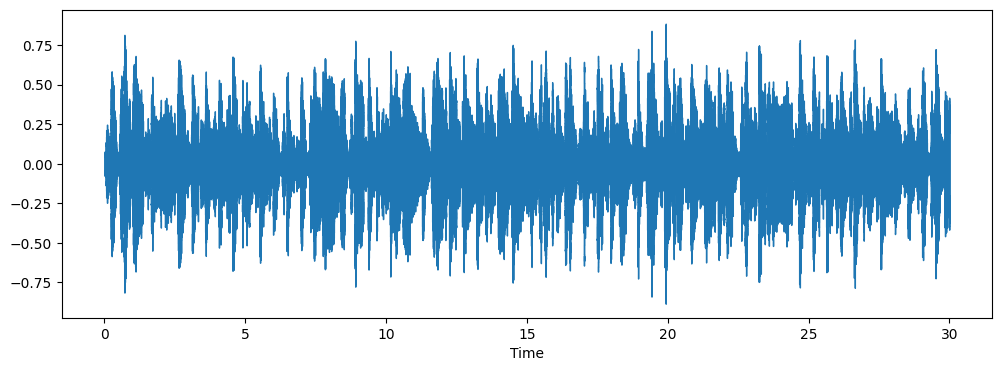

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(data)

<ipython-input-7-6ff8b0ee93be>:4: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')


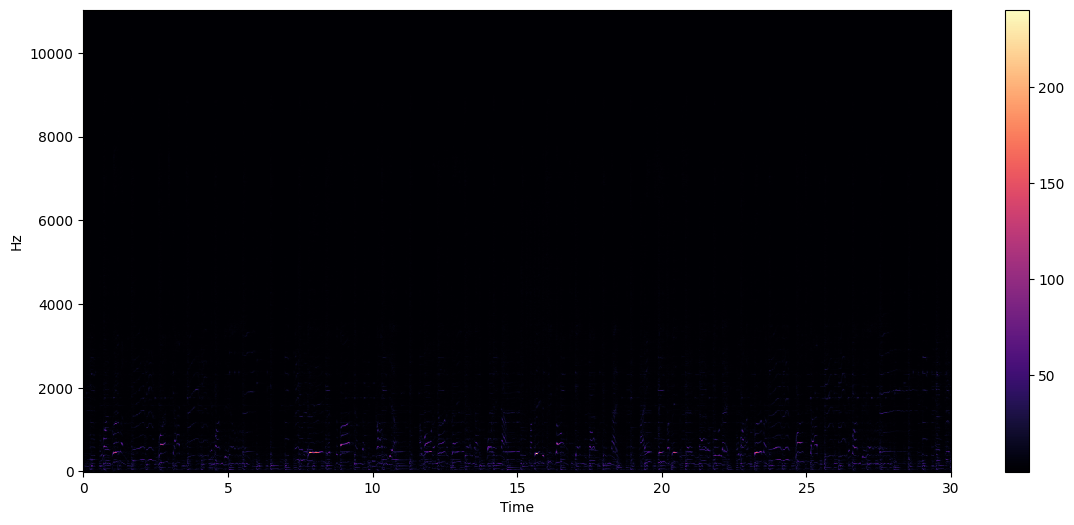

In [ ]:
stft = librosa.stft(data)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

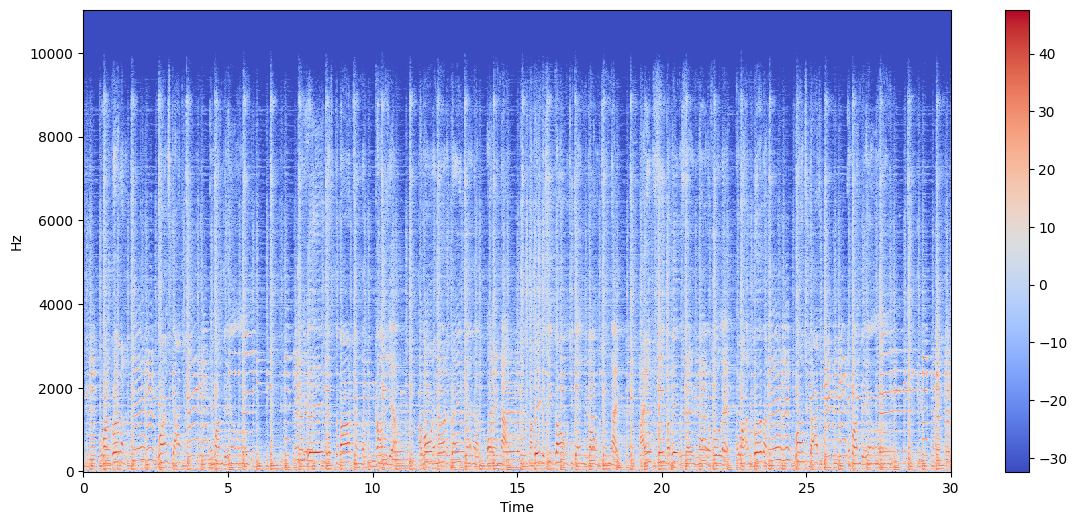

In [ ]:
plt.figure(figsize=(14, 6))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

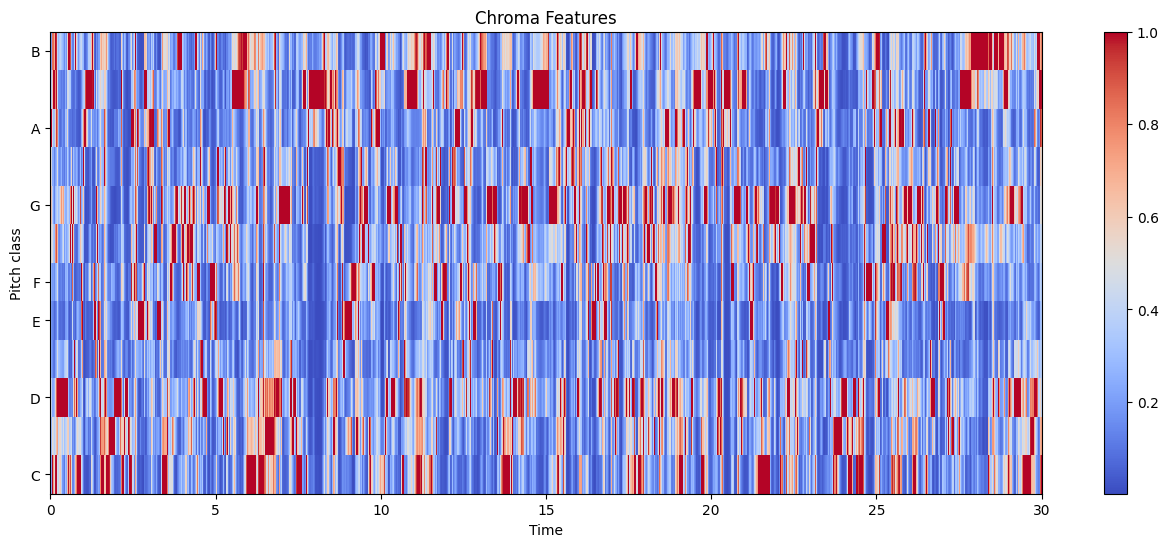

In [ ]:
chroma = librosa.feature.chroma_stft(y=data, sr=sr)
plt.figure(figsize=(16, 6))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chroma Features')
plt.show()

In [ ]:
from sklearn.preprocessing import normalize
spectral_rollof = librosa.feature.spectral_rolloff(y=data + 0.01, sr=sr)[0]
print(spectral_rollof)

[4769.60449219 4597.33886719 4694.23828125 ... 2616.28417969 2982.34863281
 2950.04882812]


In [ ]:
df = df.drop(labels='filename', axis=1)

class_list = df.iloc[:, -1]
encoder = LabelEncoder()

y = encoder.fit_transform(class_list)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(np.array(df.iloc[:, :-1], dtype=float))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
def train(model, epochs, optimizer):
  batch_size = 32
  model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics='accuracy')
  return model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)


def plot(history):
  print(f"Validation accuracy: {max(history.history['val_accuracy'])}")
  pd.DataFrame(history.history).plot(figsize=(12, 6))
  plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(10, activation='softmax'),
]
)
model.summary()
model_history = train(model=model, epochs=100, optimizer='adam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

Validation accuracy: 0.7950000166893005


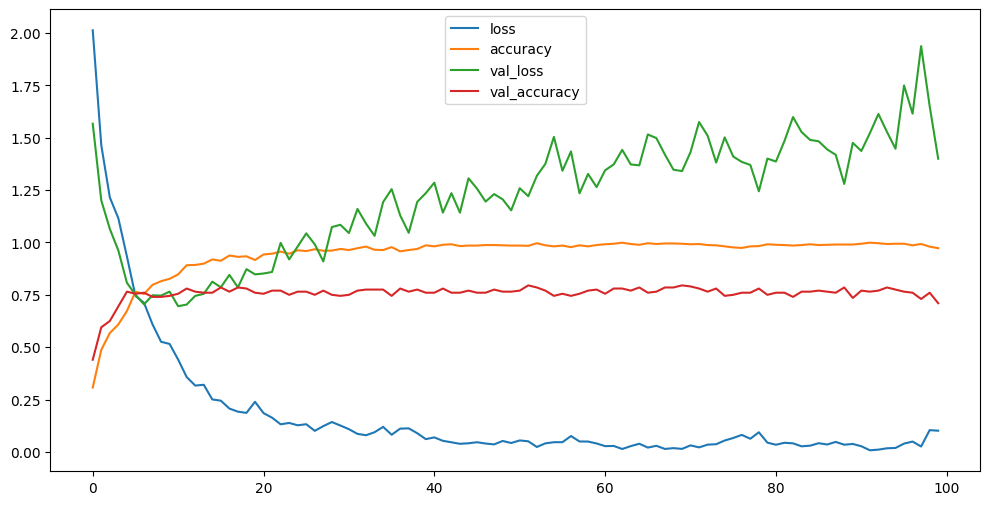

In [ ]:
plot(model_history)

In [ ]:
model.save('my_model.h5')

In [ ]:
from tqdm import tqdm


def encode_audio(path, n_segments):
  num_mfcc=20
  sample_rate=22050
  n_fft=2048
  hop_length=512
  num_segment=n_segments
  samples_per_segment = int(sample_rate*30/num_segment)

  segments_data = []
  y, sr = librosa.load(path, sr=sample_rate)

  for n in tqdm(range(num_segment)):
        data={}

        y_seg = y[samples_per_segment*n: samples_per_segment*(n+1)]
        data['length'] = int(y_seg.shape[0])

        chroma_hop_length = 512
        chromagram = librosa.feature.chroma_stft(y=y_seg, sr=sample_rate, hop_length=chroma_hop_length)
        data["chroma_stft_mean"] = (chromagram.mean())
        data["chroma_stft_var"] = (chromagram.var())

        #Root Mean Square Energy
        RMSEn= librosa.feature.rms(y=y_seg)
        data["rms_mean"] = (RMSEn.mean())
        data["rms_var"] = (RMSEn.var())

        #Spectral Centroid
        spec_cent=librosa.feature.spectral_centroid(y=y_seg)
        data["spectral_centroid_mean"] = (spec_cent.mean())
        data["spectral_centroid_var"] = (spec_cent.var())

        #Spectral Bandwith
        spec_band=librosa.feature.spectral_bandwidth(y=y_seg,sr=sample_rate)
        data["spectral_bandwidth_mean"] = (spec_band.mean())
        data["spectral_bandwidth_var"] = (spec_band.var())

        #Rolloff
        spec_roll=librosa.feature.spectral_rolloff(y=y_seg,sr=sample_rate)
        data["rolloff_mean"] = (spec_roll.mean())
        data["rolloff_var"] = (spec_roll.var())

        #Zero Crossing Rate
        zero_crossing=librosa.feature.zero_crossing_rate(y=y_seg)
        data["zero_crossing_rate_mean"] = (zero_crossing.mean())
        data["zero_crossing_rate_var"] = (zero_crossing.var())

        #Harmonics and Perceptrual
        harmony, perceptr = librosa.effects.hpss(y=y_seg)
        data["harmony_mean"] = (harmony.mean())
        data["harmony_var"] = (harmony.var())
        data["perceptr_mean"] = (perceptr.mean())
        data["perceptr_var"] = (perceptr.var())

        #Tempo
        tempo, _ = librosa.beat.beat_track(y=y_seg, sr=sample_rate)
        data["tempo"] = (tempo)

        #MFCC
        mfcc=librosa.feature.mfcc(y=y_seg,sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc=mfcc.T
        for x in range(20):
            feat1 = "mfcc" + str(x+1) + "_mean"
            feat2 = "mfcc" + str(x+1) + "_var"
            data[feat1] = (mfcc[:,x].mean())
            data[feat2] = (mfcc[:,x].var())

        segments_data.append(data)
  return segments_data

In [ ]:
def predict(data):
  predictions = model(data)
  preds = {k: [] for k in range(10)}
  for prediction in predictions:
    for index, res in enumerate(prediction):
      preds[index].append(res)

  preds = {encoder.inverse_transform([k])[0]: np.mean(v) for k, v in preds.items()}
  return {k: f"{round(v*100, 2)} %" for k, v in dict(sorted(preds.items(), key=lambda item: item[1], reverse=True)).items()}

In [ ]:
def predict_audio(path, n_segments=10):
  data = encode_audio(path, n_segments)
  df = pd.DataFrame(data)
  scaler = StandardScaler()
  X = scaler.fit_transform(np.array(df.iloc[:, :], dtype=float))
  preds = predict(X)
  return preds


100%|██████████| 10/10 [00:04<00:00,  2.08it/s]


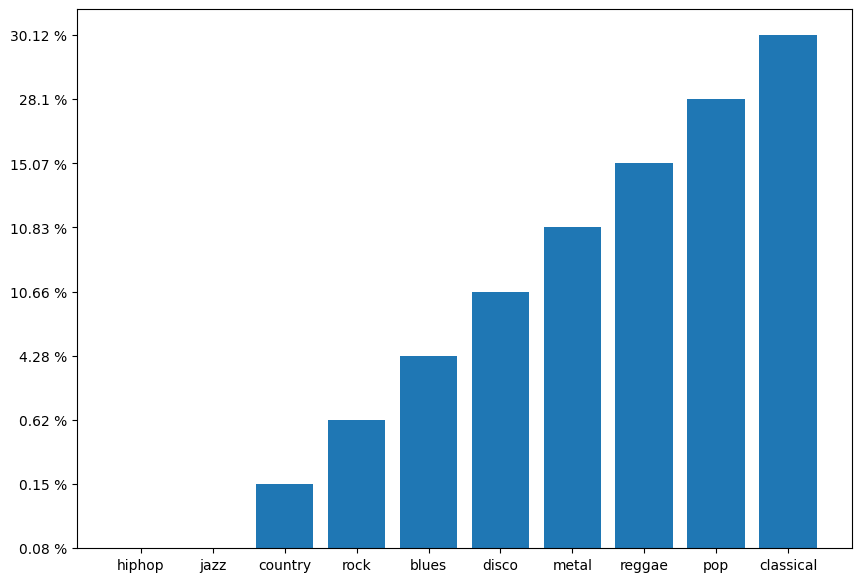

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import csv
audio_test = '/content/drive/MyDrive/Johnny Cash - Ring Of Fire (Album Version).wav'
preds = predict_audio(audio_test)
with open('preds.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['key', 'value'])
    writer.writerows(preds.items())
data = pd.read_csv(r"preds.csv")
data.head()
df = pd.DataFrame(data)
genre = df['key'].head(10)
val = df['value'].head(10)
fig = plt.figure(figsize =(10, 7))
plt.bar(genre[0:10], val[::-1])
plt.show()